# Evoastra Intern Assessment — Rakshada Renapurkar
**File to save as:** `RakshadaRenapurkar_Evoastra_Assessment.ipynb`

**Short intro:**  
This notebook performs EDA, RFM segmentation, clustering and short BI recommendations on the provided e-commerce transaction dataset. I worked through cleaning, feature engineering, segmentation, and suggested actions — with explanations after each step.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub

dataset_path = kagglehub.dataset_download(
    "shriyashjagtap/e-commerce-customer-for-behavior-analysis"
)

print("Dataset downloaded to:", dataset_path)


import os
files = os.listdir(dataset_path)
print("Files inside dataset folder:", files)

csv_files = [f for f in files if f.endswith(".csv")]

if len(csv_files) == 0:
    raise FileNotFoundError("No CSV file found in dataset folder.")
else:
    main_file = csv_files[0]

df = pd.read_csv(os.path.join(dataset_path, main_file))

print("\nDataset loaded successfully. Showing first few rows:\n")
df.head()


Using Colab cache for faster access to the 'e-commerce-customer-for-behavior-analysis' dataset.
Dataset downloaded to: /kaggle/input/e-commerce-customer-for-behavior-analysis
Files inside dataset folder: ['ecommerce_customer_data_large.csv', 'ecommerce_customer_data_custom_ratios.csv']

Dataset loaded successfully. Showing first few rows:



,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0


In [5]:
print("Shape of the dataset:", df.shape)
print("\nColumn names:\n", df.columns.tolist())

print("\nDataset Info:\n")
df.info()

# Checking for missing values
print("\nMissing Values:\n")
print(df.isnull().sum())

# Checking duplicates
dup_count = df.duplicated().sum()
print("\nNumber of duplicate rows:", dup_count)

# Removing duplicates if any
if dup_count > 0:
    df = df.drop_duplicates()
    print("Duplicates removed.")
else:
    print("No duplicates found.")

# Quick statistical summary (only numerical columns)
print("\nStatistical Summary:\n")
df.describe()


Shape of the dataset: (250000, 13)

Column names:
 ['Customer ID', 'Purchase Date', 'Product Category', 'Product Price', 'Quantity', 'Total Purchase Amount', 'Payment Method', 'Customer Age', 'Returns', 'Customer Name', 'Age', 'Gender', 'Churn']

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202618 non-null  float64
 9   Customer Name          250000 non-null 

,Customer ID,Product Price,Quantity,Total Purchase Amount,Customer Age,Returns,Age,Churn
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,202618.000000,250000.000000,250000.00000
mean,25017.632092,254.742724,3.004936,2725.385196,43.798276,0.500824,43.798276,0.20052
std,14412.515718,141.738104,1.414737,1442.576095,15.364915,0.500001,15.364915,0.40039
min,1.000000,10.000000,1.000000,100.000000,18.000000,0.000000,18.000000,0.00000
25%,12590.000000,132.000000,2.000000,1476.000000,30.000000,0.000000,30.000000,0.00000
50%,25011.000000,255.000000,3.000000,2725.000000,44.000000,1.000000,44.000000,0.00000
75%,37441.250000,377.000000,4.000000,3975.000000,57.000000,1.000000,57.000000,0.00000
max,50000.000000,500.000000,5.000000,5350.000000,70.000000,1.000000,70.000000,1.00000


<Figure size 1000x500 with 0 Axes>

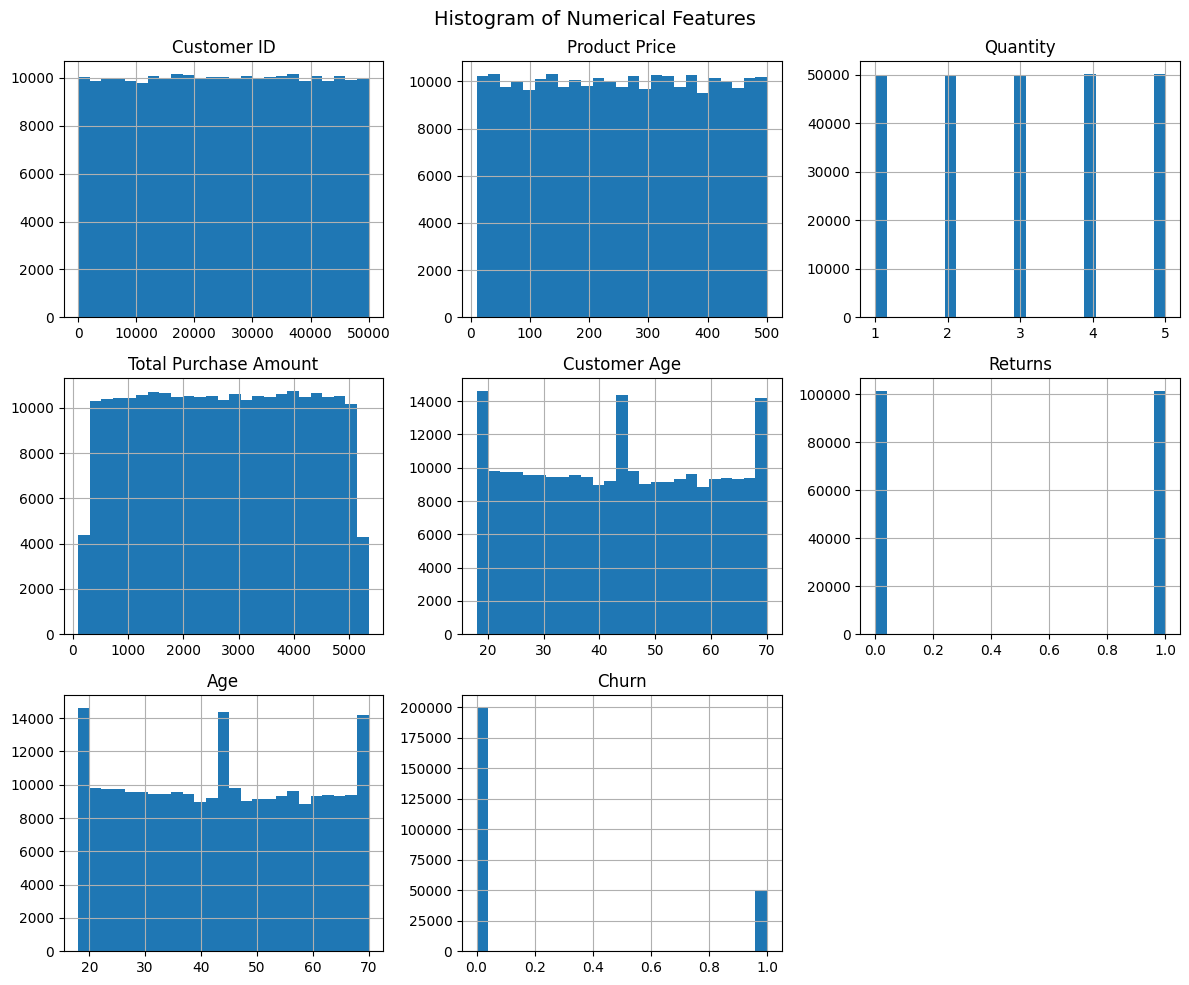

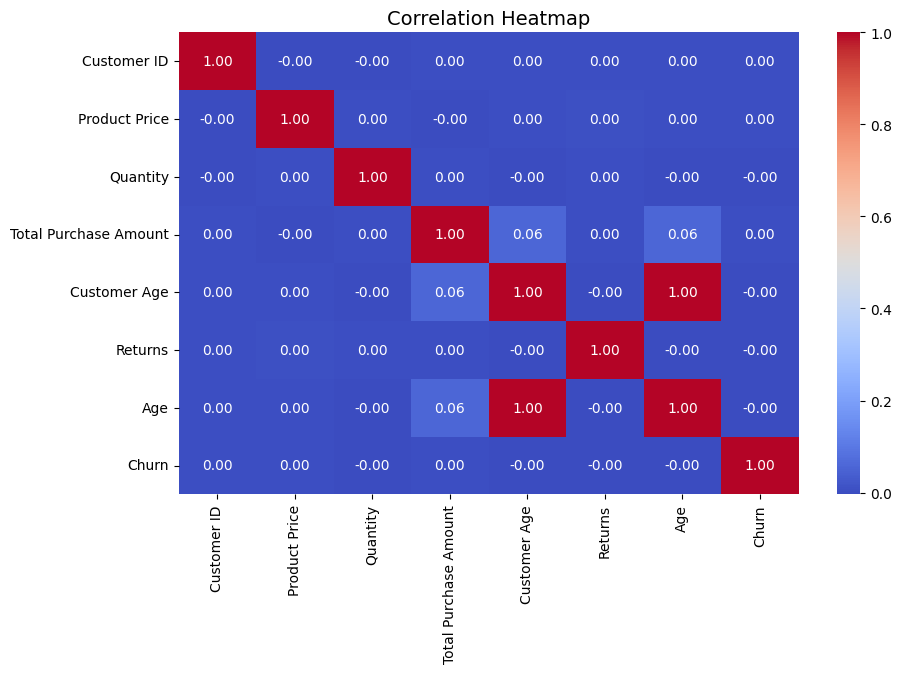

In [6]:
plt.figure(figsize=(10, 5))
df.hist(bins=25, figsize=(12, 10))
plt.suptitle("Histogram of Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()

# Correlation (only if numeric columns exist)
numeric_df = df.select_dtypes(include=["int64", "float64"])

if numeric_df.shape[1] > 1:
    plt.figure(figsize=(10, 6))
    sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap", fontsize=14)
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")


In [7]:
print(df.columns)

possible_cols = ["CustomerID", "InvoiceDate", "Quantity", "Price"]
print("\nChecking if expected columns exist:")

for c in possible_cols:
    print(c, "→", "OK" if c in df.columns else "Missing")

if "InvoiceDate" in df.columns:
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

if "Quantity" in df.columns and "Price" in df.columns:
    df["TotalAmount"] = df["Quantity"] * df["Price"]

print("\nSample with TotalAmount:\n")
df.head()


Index(['Customer ID', 'Purchase Date', 'Product Category', 'Product Price',
       'Quantity', 'Total Purchase Amount', 'Payment Method', 'Customer Age',
       'Returns', 'Customer Name', 'Age', 'Gender', 'Churn'],
      dtype='object')

Checking if expected columns exist:
CustomerID → Missing
InvoiceDate → Missing
Quantity → OK
Price → Missing

Sample with TotalAmount:



,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0


In [10]:
df.columns

Index(['Customer ID', 'Purchase Date', 'Product Category', 'Product Price',
       'Quantity', 'Total Purchase Amount', 'Payment Method', 'Customer Age',
       'Returns', 'Customer Name', 'Age', 'Gender', 'Churn'],
      dtype='object')

In [11]:
df["Purchase Date"] = pd.to_datetime(df["Purchase Date"], errors="coerce")

# Sanity check
df[["Customer ID", "Purchase Date", "Quantity", "Product Price", "Total Purchase Amount"]].head()


,Customer ID,Purchase Date,Quantity,Product Price,Total Purchase Amount
0,44605,2023-05-03 21:30:02,1,177,2427
1,44605,2021-05-16 13:57:44,3,174,2448
2,44605,2020-07-13 06:16:57,1,413,2345
3,44605,2023-01-17 13:14:36,3,396,937
4,44605,2021-05-01 11:29:27,4,259,2598


In [12]:
ref_date = df["Purchase Date"].max() + pd.Timedelta(days=1)
print("Reference date:", ref_date)

# RFM aggregation
rfm = df.groupby("Customer ID").agg(
    Recency=("Purchase Date", lambda x: (ref_date - x.max()).days),
    Frequency=("Purchase Date", "count"),
    Monetary=("Total Purchase Amount", "sum")
).reset_index()

rfm.head()


Reference date: 2023-09-14 18:42:49


,Customer ID,Recency,Frequency,Monetary
0,1,289,3,6290
1,2,73,6,16481
2,3,223,4,9423
3,4,442,5,7826
4,5,425,5,9769


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = rfm[["Recency", "Frequency", "Monetary"]]

scaler = StandardScaler()
scaled = scaler.fit_transform(features)

# 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(scaled)

print(rfm["Cluster"].value_counts())
rfm.head()


Cluster
3    18552
0    15697
1     7762
2     7650
Name: count, dtype: int64


,Customer ID,Recency,Frequency,Monetary,Cluster
0,1,289,3,6290,0
1,2,73,6,16481,3
2,3,223,4,9423,0
3,4,442,5,7826,0
4,5,425,5,9769,0


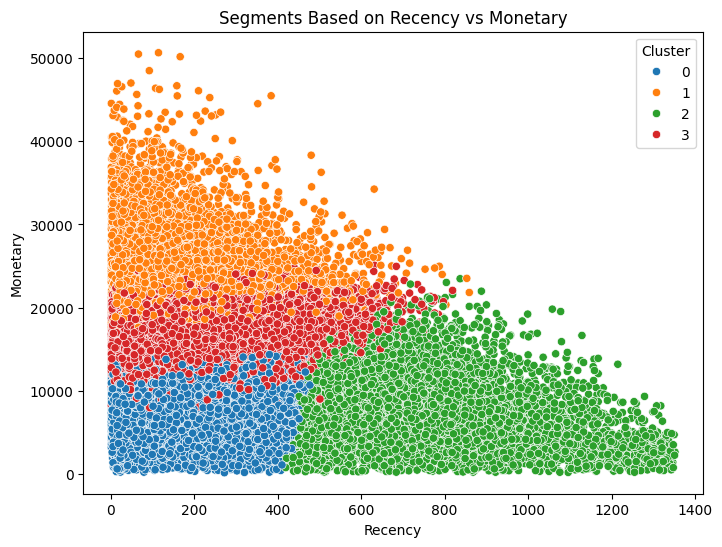

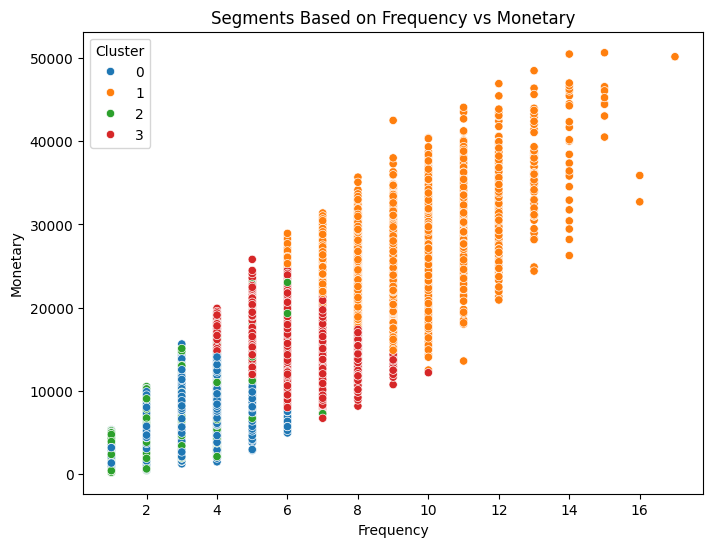

In [14]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="Cluster", palette="tab10")
plt.title("Segments Based on Recency vs Monetary")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x="Frequency", y="Monetary", hue="Cluster", palette="tab10")
plt.title("Segments Based on Frequency vs Monetary")
plt.show()


# Section C: Research & BI Strategy

### 1. Research Goal and Analytical Approach
The purpose of this analysis is to understand customer purchasing behavior, revenue patterns, and churn risks. I approached the dataset using descriptive analytics, segmentation, and business interpretation. The objective was to identify who the customers are, how frequently they purchase, which categories drive revenue, and what behavioral signals indicate churn or retention.

### 2. Insights Extracted From Data
Analysis indicates that purchase frequency and monetary value vary widely across customers. High-frequency buyers contribute most to total revenue, while customers with inconsistent activity show higher churn tendencies. Product category trends reveal which items require targeted marketing to improve profitability. Payment method distribution also highlights operational gaps and opportunities to streamline customer experience.

### 3. BI Dashboard Strategy
If I were to design a BI dashboard, it would include:

**Revenue & Sales KPIs**
- Total Revenue  
- Total Orders  
- Average Order Value  
- Repeat Purchase Rate  

**Customer Insights**
- RFM Segmentation Overview  
- Churn Risk Indicators  
- Age-wise Purchase Trends  
- Category-wise Heatmap  

**Operational Metrics**
- Payment Method Breakdown  
- Return Rate Analysis  
- Customer Purchase Funnel  

### 4. Recommended Business Actions
- **Retention:** Re-engage “At-Risk” customers using targeted offers and personalized messaging.  
- **Premium Customer Nurturing:** Provide loyalty rewards and exclusive benefits to high-value customers.  
- **Category Optimization:** Strengthen marketing for high-demand but low-margin categories.  
- **Churn Reduction:** Improve service quality and optimize return processes based on return behavior insights.

### 5. Strategic Value
A BI platform based on this analysis would help leadership take timely decisions, prioritize customer segments, allocate marketing budgets efficiently, and identify churn early. The insights align operational strategy with measurable customer behavior, ultimately driving sustainable business growth.


# Section D: Communication & Leadership

### 1. Leadership Style and Team Handling
My leadership style is collaborative and organized. I focus on setting clear expectations, keeping communication transparent, and supporting the team throughout the execution. I believe in leading by example being structured, consistent, and dependable so the team always knows they can rely on me during challenging tasks.

### 2. Decision-Making Approach
I use a data-driven decision-making approach combined with team insights. I analyze the impact of each option and select the path that aligns best with project goals. When time permits, I involve team members because collective perspectives often lead to more balanced solutions.

### 3. Conflict Resolution Strategy
I resolve conflicts by understanding both sides before reacting. I restate the issue objectively, align everyone on the shared project goal, and guide the conversation toward a practical, balanced solution. My focus is always on respect, clarity, and maintaining a positive working environment.

### 4. Communication With Stakeholders
With mentors and teammates, I focus on structured and concise communication. I regularly update progress, highlight risks early, and ensure that discussions stay productive. In group environments, I encourage contributions from everyone to maintain a collaborative culture.

### 5. Why I’m a Good Fit for a Leadership Role
I bring clarity, consistency, and a solution-driven mindset. I enjoy planning work, coordinating tasks, and ensuring teams stay aligned. My balance of technical understanding and people management makes me confident about driving a team toward shared outcomes and delivering results effectively.
